### Basic imports and setting up OpenAI and Tavily integration


In [1]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.environ['OPENAI_API_KEY_TEG'],
    temperature=0,
)


### Moj własny tool


In [52]:
from langchain.tools import Tool

def calculate_loss(time_lost_hours, avg_salary_per_hour):
    return time_lost_hours * avg_salary_per_hour

agent2_tools = [
    Tool.from_function(
        func=calculate_loss,
        name="CalculateTimeLoss",
        description="Calculates company loss due to wasted time on social media. Inputs: time in seconds, average hourly salary is 50 PLN."
    )
]


### Definicja Tools

In [ ]:
from langchain_community.utilities.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.tools.tavily_search import TavilySearchResults
import os   
from dotenv import load_dotenv
load_dotenv()

db_path = r"C:\PJATK\SEMESTR2\teg projekt\projekt\Logi-projektTEG\parser\logs.db"

sql_db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
sql_toolkit = SQLDatabaseToolkit(db=sql_db, llm=llm)  
agent1_tools = sql_toolkit.get_tools()
tavily = TavilySearchResults(max_results=5)


tools = agent1_tools + [tavily] + agent2_tools

### Defining the prompts for each agent role

In [104]:
search_template = """
                  Your job is to translate the following user question into an accurate SQL query based on the given table schema.
                  Identify the most relevant columns for answering the query.
                  Execute the SQL query and return the result.
                  Not permit risky SQL generation (e.g., DROP, DELETE) 
                  Duration is the time spent on the app by the user in seconds.
                  """
value_template = """Your job is to Calculate the financial loss caused by employees spending time on social media.

                    Return the estimated total cost of productivity loss.
                    Multiply total time lost (in hours) by the average monthly IT salary.
                    Your feedback should be in bullet point format only.
                    """
exchange_template = """Convert the total company losses into multiple currencies and assets: USD, EUR, GBP, BTC, XAU (gold).
                        Use the latest exchange rates for accurate conversion.
                        Return the result in a tabular format.
                    """

### Zdefiniowanie Agentow

In [105]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define method for creating agents and binding them to the tools
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm
    
search_agent = create_agent(
    llm,
    tools,
    system_message=search_template,
)

value_agent = create_agent(
    llm,
    tools,
    system_message=value_template,
)

exchange_agent = create_agent(
    llm,
    tools,
    system_message=value_template,
)

In [138]:
import functools


def agent_node(state, agent, name):
    print(f"[DEBUG] Running agent: {name}")
    print(f"[DEBUG] Input messages: {[msg.content for msg in state['messages']]}")

    result = agent.invoke(state)
    
    # Zabezpieczenie na wypadek, gdyby wynik nie był wiadomością
    if hasattr(result, "content"):
        print(f"[DEBUG] Output from {name}: {result.content}")
    else:
        print(f"[DEBUG] Output from {name}: {result}")
    
    return {
        "messages": state["messages"] + [result],
        "no_of_iterations": state["no_of_iterations"] + 1
    }

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
value_node = functools.partial(agent_node, agent=value_agent, name="Value Agent")
exchange_node = functools.partial(agent_node, agent=exchange_agent, name="Exchange Agent")



### Funkcje w grafie


In [139]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph import END, StateGraph

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  no_of_iterations: int

# 1. funkcja
def check_time_node(state) -> AgentState:
    next_path = check_if_answer_about_time(state)  
    return {
        **state,
        "next_path": next_path
    }

# 2. Funkcja decyzji: czy odpowiedź zawiera czas
def check_if_answer_about_time(state) -> Literal["value", "natural"]:
    content = state["messages"][-1].content.lower()
    
    if ("time" in content or
        "spent" in content and "hours" in content or
        "second" in content or
        "seconds" in content):
        return "value" # odpowiedź zawiera info o czasie
    return "natural"  # odpowiedź nie zawiera info o czasie

# 3. Funkcja końcowa: odpowiedź językiem naturalnym
def natural_language_answer(state) -> AgentState:
    return {
        "messages": state["messages"] + [AIMessage(content="Answer in natural language to the prompt")],
        "no_of_iterations": state["no_of_iterations"]
    }


### GRAF - WYŚWIETLANIE


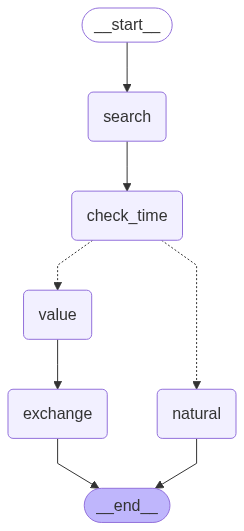

In [140]:
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages


workflow = StateGraph(AgentState)

tool_node = ToolNode(tools)

# Dodajemy węzły
workflow.add_node("search", search_node)
workflow.add_node("check_time", check_time_node)
workflow.add_node("value", value_node)
workflow.add_node("exchange", exchange_node)
workflow.add_node("natural", natural_language_answer)


# Set the entrypoint as `search`
# This means that this node is the first one called
workflow.set_entry_point("search")

# Add the edges
workflow.add_edge("search", "check_time")

workflow.add_conditional_edges(
    "check_time",
    lambda state: state["next_path"],  # warunek to teraz wartość z dict
    {
        "value": "value",
        "natural": "natural"
    }
)

workflow.add_edge("value", "exchange")
workflow.add_edge("natural", END)
workflow.add_edge("exchange", END)


graph = workflow.compile()

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

### Running and testing the implementation

In [136]:
from langchain.chains import create_sql_query_chain

chain = create_sql_query_chain(llm, sql_db)
response = chain.invoke({"question": "Ile akcji ( action) ze statusem close było 16.05.2025? "})
response



'SQLQuery: SELECT COUNT("action") AS "close_action_count" FROM logs WHERE "date" = \'2025-05-16\' AND "action" = \'close\';'

In [125]:
# Let's review it
print(response)

SQLQuery: SELECT COUNT("action") AS "close_action_count" FROM logs WHERE "date" = '2025-05-16' AND "action" = 'close';


In [126]:
# Try simple fix
response = response.replace("SQLQuery: ", "").replace("```", "").replace("\n", "").replace("sql", "")
response

'SELECT COUNT("action") AS "close_action_count" FROM logs WHERE "date" = \'2025-05-16\' AND "action" = \'close\';'

In [127]:
sql_db.run(response)

'[(6522,)]'

In [141]:
from langchain_core.messages import HumanMessage, AIMessage

print("\n[START] Testowanie LangGraph:\n")

prompt = "Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?"

input_data = {
    "messages": [HumanMessage(content=prompt)],
    "no_of_iterations": 0
}

for i, event in enumerate(graph.stream(input_data, stream_mode="values")):
    print(f"\n--- [KROK {i+1}] ---")
    for msg in event["messages"]:
        role = "HUMAN" if msg.type == "human" else "AI"
        print(f"{role}: {msg.content}")


[START] Testowanie LangGraph:


--- [KROK 1] ---
HUMAN: Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?
[DEBUG] Running agent: Search Agent
[DEBUG] Input messages: ['Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?']
[DEBUG] Output from Search Agent: 

--- [KROK 2] ---
HUMAN: Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?
AI: 

--- [KROK 3] ---
HUMAN: Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?
AI: 

--- [KROK 4] ---
HUMAN: Ile czasu zajęło wykonanie akcji ( action) ze statusem close 16.05.2025?
AI: 
AI: Answer in natural language to the prompt
